#### 라이브러리 호출

In [1]:
from scripts.dataloader import create_loader, plot_images, plot_test_images
from scripts.model import VisionTransformer
from scripts.train import train, evaluate, test

import torch
import torch.nn as nn
import torch.optim as optim
import torch.amp as amp

from torchinfo import summary

import random
import os
import tomli
from tqdm.auto import tqdm

#### 유틸함수 정의

In [2]:
def set_seed(seed):
    """ 재현성을 위한 시드 고정 """
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def load_config(toml_path):
    """ TOML 파일에서 config 불러오기 """
    with open(toml_path, 'rb') as file:
        return tomli.load(file)

#### 데이터로더 불러오기

In [3]:
# 1. 파라미터 불러오기
config_path = './config/config.toml'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cfg = load_config(config_path)
data_cfg = cfg.get("data", {})
train_cfg = cfg.get("train", {})
model_cfg = cfg.get("model", {})

# 2. 데이터로더 정의
train_loader, valid_loader, test_loader, class_to_idx = create_loader(
    data_path=data_cfg['data_dir'], batch_size=train_cfg['batch_size'], valid_ratio=data_cfg['vaild_ratio'])

print("  images, labels 정보  ".center(60, '='))
images, labels = next(iter(train_loader))
print(images.shape)
print(labels)
print(class_to_idx)

Files already downloaded and verified
Files already downloaded and verified
===========  train, valid, test datasets 데이터 개수  ===========
50000, 5000, 5000
===================  images, labels 정보  ====================
torch.Size([128, 3, 32, 32])
tensor([0, 6, 1, 3, 1, 4, 9, 7, 1, 8, 9, 3, 8, 1, 8, 0, 0, 6, 1, 8, 0, 6, 2, 6,
        1, 8, 0, 2, 5, 3, 5, 3, 4, 4, 0, 9, 2, 9, 4, 8, 3, 5, 9, 0, 4, 7, 0, 8,
        2, 5, 8, 0, 2, 8, 1, 3, 4, 9, 8, 8, 4, 4, 6, 3, 0, 5, 1, 5, 5, 2, 4, 3,
        5, 9, 2, 3, 6, 0, 5, 6, 5, 5, 1, 8, 0, 6, 9, 5, 0, 5, 2, 4, 7, 2, 8, 1,
        1, 6, 5, 9, 2, 4, 1, 9, 6, 3, 1, 5, 0, 2, 0, 5, 5, 6, 9, 3, 1, 7, 5, 4,
        1, 7, 4, 5, 3, 3, 5, 1])
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


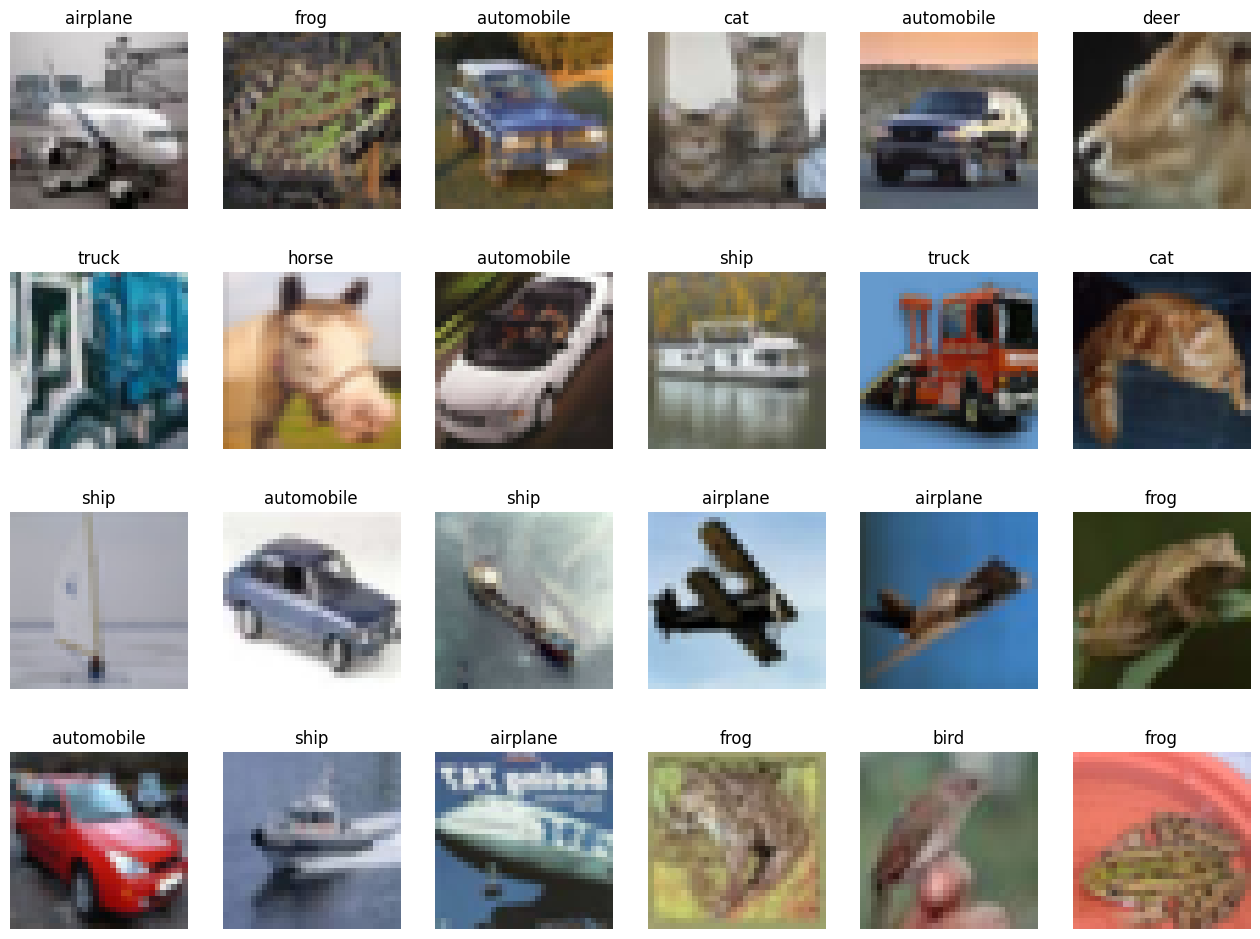

In [4]:
# 3. 이미지 시각화
plot_images(images, labels, class_to_idx)

#### 모델 불러오기

In [5]:
# 1. 모델 호출
model = VisionTransformer(
    img_size     = model_cfg['img_size'],
    patch_size   = model_cfg['patch_size'],
    num_classes  = len(class_to_idx),
    embed_dim    = model_cfg['embed_dim'],
    depth        = model_cfg['depth'],
    num_heads    = model_cfg['num_heads'],
    mlp_ratio    = model_cfg['mlp_ratio'],
    dropout      = model_cfg['dropout'],
    attn_dropout = model_cfg['attn_dropout']).to(device)

# 2. 모델 요약
summary(model, input_size=images.size())

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [128, 10]                 --
├─PatchEmbedConv: 1-1                         [128, 64, 192]            --
│    └─Conv2d: 2-1                            [128, 192, 8, 8]          9,408
├─AddClsToken: 1-2                            [128, 65, 192]            192
├─PositionalEmbedding: 1-3                    [128, 65, 192]            12,480
│    └─Dropout: 2-2                           [128, 65, 192]            --
├─Encoder: 1-4                                [128, 65, 192]            --
│    └─ModuleList: 2-3                        --                        --
│    │    └─EncoderBlock: 3-1                 [128, 65, 192]            444,864
│    │    └─EncoderBlock: 3-2                 [128, 65, 192]            444,864
│    │    └─EncoderBlock: 3-3                 [128, 65, 192]            444,864
│    │    └─EncoderBlock: 3-4                 [128, 65, 192]            

#### 손실함수/옵티마이저/스케쥴러

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=train_cfg['lr'], weight_decay=train_cfg['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_cfg['epochs'])
scaler    = amp.GradScaler(device.type, enabled=device.type == 'cuda')

#### 모델 학습

In [7]:
os.makedirs(train_cfg['save_dir'], exist_ok=True)
best_path = os.path.join(train_cfg['save_dir'], 'vit_best.pt')

In [ ]:
best_acc = 0.0
for epoch in tqdm(range(1, train_cfg['epochs'] + 1), desc='epochs', total=train_cfg['epochs'], 
                  colour='#BAFF1A', position=0):
    train_loss, train_acc, lr = train(model, train_loader, criterion, optimizer, scheduler, scaler, device,
                                      max_norm=train_cfg['grad_clip'])
    valid_loss, valid_acc     = evaluate(model, valid_loader, criterion, device)
    
    print(f"[Epoch {epoch:02d}] train_loss={train_loss:.4f} train_acc={train_acc*100:.2f}% "
            f"valid_loss={valid_loss:.4f} valid_acc={valid_acc*100:.2f}% lr={lr:.6f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save({
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'scaler_state': scaler.state_dict()}, best_path)
        print(f"  -> 새 베스트 모델 저장: {best_path}")

#### 모델 테스트

In [8]:
ckpt = torch.load(best_path, map_location=device, weights_only=False)
model.load_state_dict(ckpt['model_state'])

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"test_loss={test_loss:.4f} test_acc={test_acc*100:.2f}%")

eval:   0%|          | 0/40 [00:00<?, ?it/s]

test_loss=1.1388 test_acc=74.62%


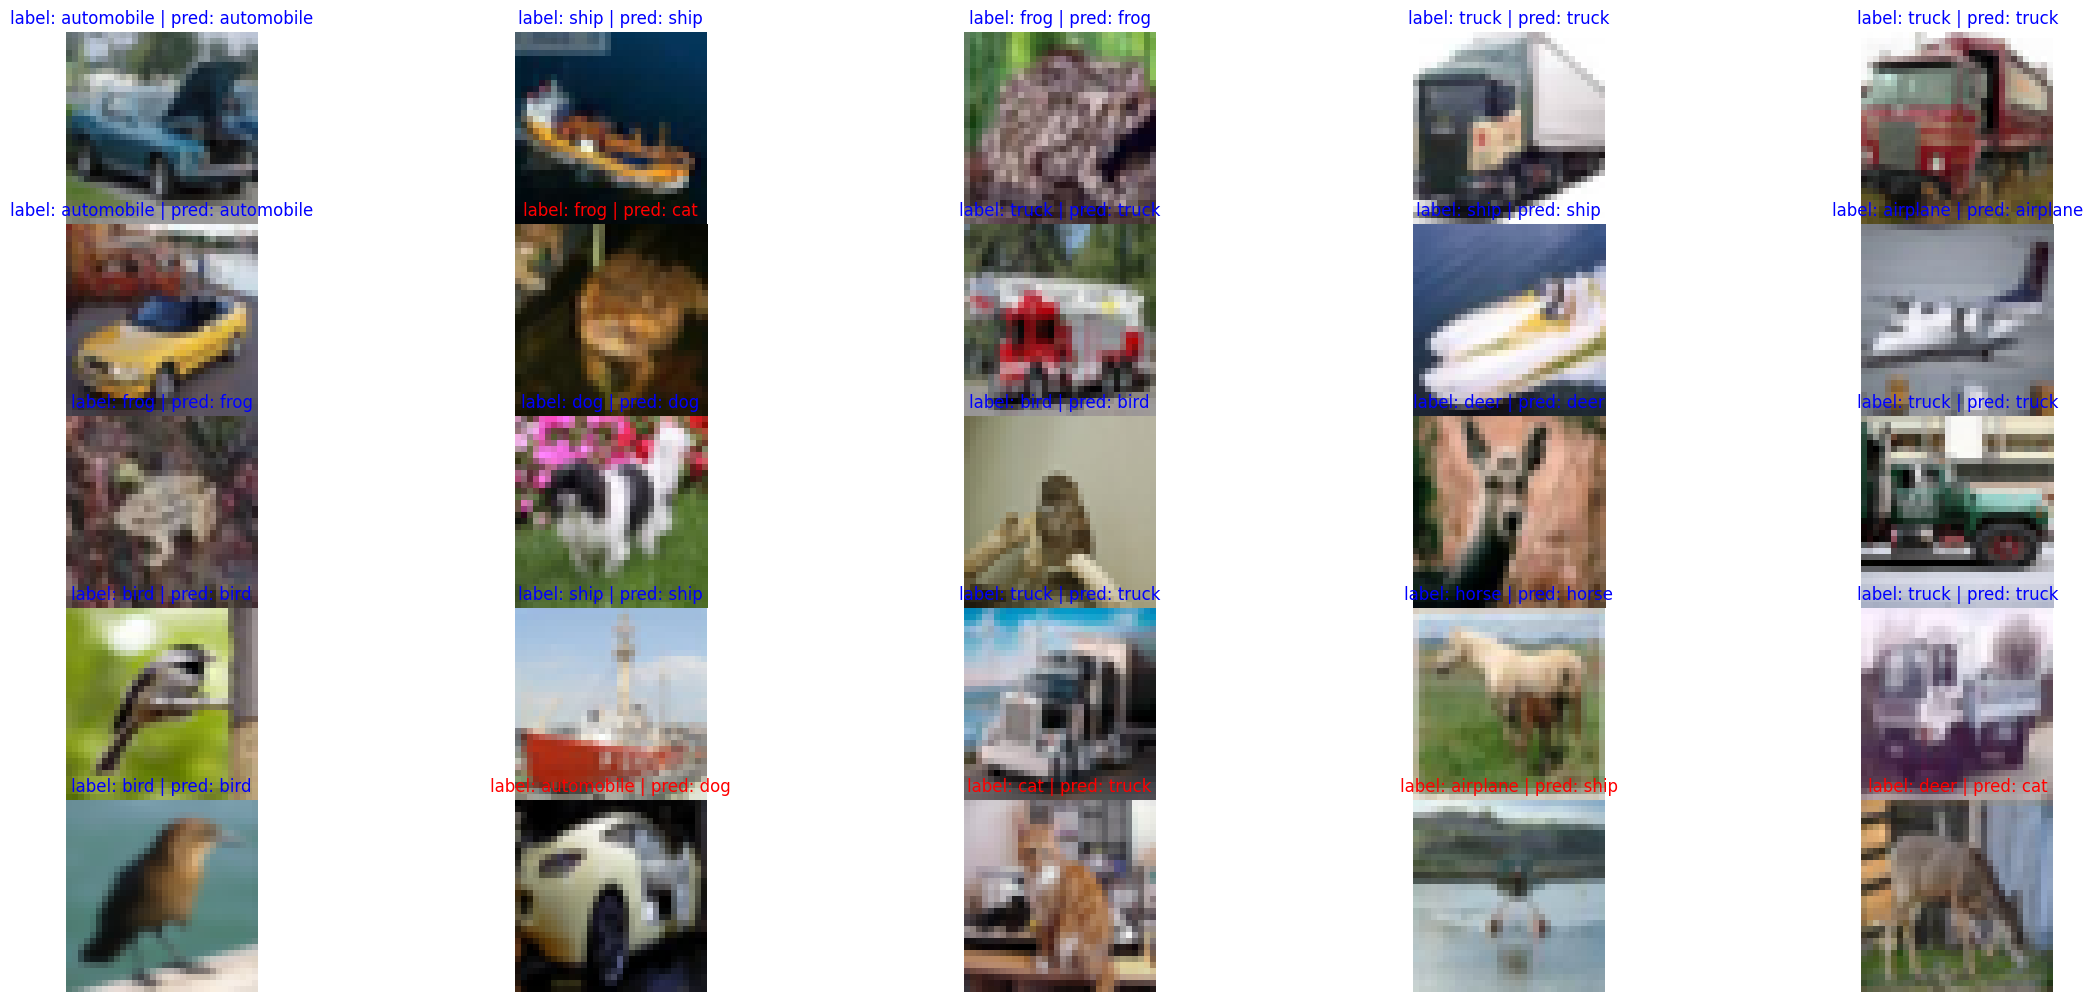

In [9]:
images, labels = next(iter(test_loader))

preds = test(model, images, labels, device)
plot_test_images(images, labels, preds, class_to_idx)